<a href="https://colab.research.google.com/github/jjome/dl_cg/blob/master/cycleGAN_model1_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision pillow numpy matplotlib

### Colab 마운트

In [2]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# FOLDERNAME = 'test'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# import sys
# sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# # Change directory to current folder
# %cd /content/drive/MyDrive/$FOLDERNAME

In [3]:
!git clone https://github.com/jjome/dl_cg.git

fatal: destination path 'dl_cg' already exists and is not an empty directory.


필요한 라이브러리 import

In [4]:
import os
import shutil
import itertools
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

### 사진 파일 불러오기

'dataset' 파일 안에 'older' 파일과 'younger' 파일이 있는 형태여야 함

In [5]:
# Define the base directories
target_dir = '/content/dl_cg/dataset4'
older_dir = os.path.join(target_dir, 'older')
younger_dir = os.path.join(target_dir, 'younger')

### transformations, dataloaders, batch size

In [6]:
# Step 3: Run the PyTorch code
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    #transforms.RandomRotation(degrees=10),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define dataset and dataloaders
older_dataset = datasets.ImageFolder(root=older_dir, transform=transform)
younger_dataset = datasets.ImageFolder(root=younger_dir, transform=transform)

# Ensure drop_last=True to handle incomplete batches
batch_size = 32
older_dataloader = DataLoader(older_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
younger_dataloader = DataLoader(younger_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

# Example: Print first few images to verify
older_img, older_label = next(iter(older_dataloader))
younger_img, younger_label = next(iter(younger_dataloader))

print("Shape of older image batch:", older_img.shape)
print("Shape of younger image batch:", younger_img.shape)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Shape of older image batch: torch.Size([32, 3, 256, 256])
Shape of younger image batch: torch.Size([32, 3, 256, 256])


### generator, discriminator

In [7]:
import torch.nn as nn

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


### cycleGAN 정의하기

In [8]:
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.G_XtoY = Generator()
        self.G_YtoX = Generator()
        self.D_X = Discriminator()
        self.D_Y = Discriminator()

    def forward(self):
        pass

# Instantiate the model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cycle_gan = CycleGAN().to(device)
print(device)


cpu


### loss function, optimizer

In [9]:
import itertools
import torch.optim as optim

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(cycle_gan.G_XtoY.parameters(), cycle_gan.G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(cycle_gan.D_X.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(cycle_gan.D_Y.parameters(), lr=0.0001, betas=(0.5, 0.999))


### model training

In [ ]:
# Training loop
# num_epochs = 100
num_epochs = 5
for epoch in range(num_epochs):
    for i, (data_X, data_Y) in enumerate(zip(older_dataloader, younger_dataloader)):
        # Get real images
        real_X = data_X[0].to(device)
        real_Y = data_Y[0].to(device)

        # Adversarial ground truths with the same shape as discriminator outputs
        valid = torch.ones(real_X.size(0), 1, 15, 15, dtype=torch.float, requires_grad=False).to(device)
        fake = torch.zeros(real_X.size(0), 1, 15, 15, dtype=torch.float, requires_grad=False).to(device)

        # ----------------------
        #  Train Generators
        # ----------------------

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_X = criterion_identity(cycle_gan.G_YtoX(real_X), real_X)
        loss_id_Y = criterion_identity(cycle_gan.G_XtoY(real_Y), real_Y)

        loss_identity = (loss_id_X + loss_id_Y) / 2

        # GAN loss
        fake_Y = cycle_gan.G_XtoY(real_X)
        loss_GAN_XtoY = criterion_GAN(cycle_gan.D_Y(fake_Y), valid)

        fake_X = cycle_gan.G_YtoX(real_Y)
        loss_GAN_YtoX = criterion_GAN(cycle_gan.D_X(fake_X), valid)

        loss_GAN = (loss_GAN_XtoY + loss_GAN_YtoX) / 2

        # Cycle loss
        recov_X = cycle_gan.G_YtoX(fake_Y)
        loss_cycle_X = criterion_cycle(recov_X, real_X)

        recov_Y = cycle_gan.G_XtoY(fake_X)
        loss_cycle_Y = criterion_cycle(recov_Y, real_Y)

        loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

        # Total loss
        loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # Adjust output range of generated images
        fake_Y = (fake_Y + 1) / 2  # Map from [-1, 1] to [0, 1]
        fake_X = (fake_X + 1) / 2  # Map from [-1, 1] to [0, 1]

        # ----------------------
        #  Train Discriminators
        # ----------------------

        # Discriminator X
        optimizer_D_X.zero_grad()

        loss_real_X = criterion_GAN(cycle_gan.D_X(real_X), valid)
        loss_fake_X = criterion_GAN(cycle_gan.D_X(fake_X.detach()), fake)

        loss_D_X = (loss_real_X + loss_fake_X) / 2

        loss_D_X.backward()
        optimizer_D_X.step()

        # Discriminator Y
        optimizer_D_Y.zero_grad()

        loss_real_Y = criterion_GAN(cycle_gan.D_Y(real_Y), valid)
        loss_fake_Y = criterion_GAN(cycle_gan.D_Y(fake_Y.detach()), fake)

        loss_D_Y = (loss_real_Y + loss_fake_Y) / 2

        loss_D_Y.backward()
        optimizer_D_Y.step()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(older_dataloader)}] "
              f"[D loss: {loss_D_X.item() + loss_D_Y.item()}] [G loss: {loss_G.item()}]")


[Epoch 0/5] [Batch 0/66] [D loss: 0.5256150960922241] [G loss: 12.734230995178223]


In [ ]:
cycle_gan.eval

## training한 모델 저장하기

In [ ]:
# Save the model
torch.save(cycle_gan.state_dict(), '/content/drive/MyDrive/deep_learning/cycle_gan_model2.pth')
torch.save(cycle_gan.state_dict(), 'cycle_gan_state_dict.pth')

### trained된 모델로 이미지 넣어 결과물 보기

우선 저장된 모델 불러오기

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming you have defined your CycleGAN model class (CycleGAN) and its architecture

# Instantiate the CycleGAN model
cycle_gan = CycleGAN()

# Load the trained model weights
model_path = '/content/drive/MyDrive/test/cycle_gan_model1.pth'

cycle_gan.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
cycle_gan.eval()

# Move the model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cycle_gan.to(device)


CycleGAN(
  (G_XtoY): Generator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      (14): ConvTrans

input 이미지 사진 transform하고 tensor로 변환하기

In [ ]:
# Define transformations for the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the model's input size
    transforms.ToTensor(),  # Convert PIL image to tensor
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess the test image
input_image_path = '/content/drive/MyDrive/deep_learning/older_face1.jpg'
input_image = Image.open(input_image_path).convert('RGB')
input_tensor = transform(input_image).unsqueeze(0).to(device)


In [ ]:
output_tensor

tensor([[[[-0.1301, -0.1371, -0.1335,  ..., -0.1367, -0.1336, -0.1269],
          [-0.1341, -0.0983, -0.1355,  ..., -0.0975, -0.1352, -0.1116],
          [-0.1406, -0.1379, -0.1421,  ..., -0.1429, -0.1411, -0.1321],
          ...,
          [-0.1333, -0.0975, -0.1374,  ..., -0.0978, -0.1363, -0.1096],
          [-0.1404, -0.1404, -0.1395,  ..., -0.1445, -0.1398, -0.1290],
          [-0.1384, -0.1082, -0.1397,  ..., -0.1106, -0.1406, -0.1214]],

         [[-0.1050, -0.1187, -0.1042,  ..., -0.1212, -0.1020, -0.1065],
          [-0.1124, -0.0901, -0.0928,  ..., -0.0915, -0.0897, -0.0891],
          [-0.1186, -0.1476, -0.1287,  ..., -0.1433, -0.1311, -0.1263],
          ...,
          [-0.1132, -0.0887, -0.0922,  ..., -0.0896, -0.0930, -0.0902],
          [-0.1176, -0.1493, -0.1308,  ..., -0.1459, -0.1332, -0.1269],
          [-0.1156, -0.1119, -0.1025,  ..., -0.1133, -0.1023, -0.1081]],

         [[ 0.0940,  0.0955,  0.0792,  ...,  0.0936,  0.0787,  0.0970],
          [ 0.0904,  0.0928,  

In [ ]:
input_tensor

tensor([[[[ 0.2941,  0.2941,  0.2863,  ...,  0.2471,  0.2549,  0.2627],
          [ 0.2863,  0.2863,  0.2784,  ...,  0.2471,  0.2549,  0.2627],
          [ 0.2784,  0.2784,  0.2706,  ...,  0.2392,  0.2549,  0.2627],
          ...,
          [ 0.0039,  0.0039,  0.0118,  ...,  0.1137,  0.1451,  0.2000],
          [ 0.0039,  0.0118,  0.0118,  ...,  0.1059,  0.0196, -0.1059],
          [ 0.0118,  0.0118,  0.0118,  ...,  0.0275, -0.1373, -0.3647]],

         [[ 0.1059,  0.1059,  0.0980,  ...,  0.0667,  0.0745,  0.0824],
          [ 0.0980,  0.0980,  0.0902,  ...,  0.0667,  0.0745,  0.0824],
          [ 0.0902,  0.0902,  0.0824,  ...,  0.0588,  0.0745,  0.0824],
          ...,
          [-0.1216, -0.1216, -0.1137,  ..., -0.0039,  0.0275,  0.0824],
          [-0.1216, -0.1137, -0.1137,  ..., -0.0118, -0.0980, -0.2235],
          [-0.1137, -0.1137, -0.1137,  ..., -0.0902, -0.2549, -0.4824]],

         [[-0.0980, -0.0980, -0.1059,  ..., -0.2000, -0.1922, -0.1843],
          [-0.1059, -0.1059, -

### output tensor 다시 이미지로 변환하고 결과물 저장하기

In [ ]:
with torch.no_grad():
  # Perform translation
  output_tensor = cycle_gan.G_XtoY(input_tensor)  # Assuming you want to translate to domain Y

  # Convert the output tensor to a PIL image
  output_ts = output_tensor.squeeze().cuda()
  #output_ts1 = output_ts * 0.5 + 0.5
  output_image = transforms.ToPILImage()(output_ts)

  # Display or save the translated image
  output_image.show()

  # Or save it to a file
  output_image.save('/content/drive/MyDrive/test/translated_image5.png')


In [ ]:
output_ts1.shape

torch.Size([3, 256, 256])

In [ ]:
output_tensor.shape

torch.Size([1, 3, 256, 256])

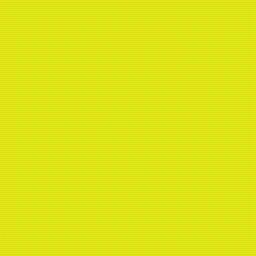

In [ ]:
output_image

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

with torch.no_grad():
    # Perform translation
    output_tensor = cycle_gan.G_XtoY(input_tensor)  # Assuming you want to translate to domain Y

    # Squeeze the output tensor and move to CPU if necessary
    output_ts = output_tensor.squeeze().cuda()

    # Check tensor values
    print(f'Tensor min: {output_ts.min()}')
    print(f'Tensor max: {output_ts.max()}')
    print(f'Tensor mean: {output_ts.mean()}')
    print(f'Tensor shape: {output_ts.shape}')

    # Denormalize the tensor (assuming the model output is in the range [-1, 1])
    output_ts = (output_ts + 1) * 0.5

    # Optionally scale to [0, 255]
    output_ts = output_ts

    # Convert the tensor to a PIL image
    output_image = transforms.ToPILImage()(output_ts)

    # Display or save the translated image
    output_image.show()

    # Or save it to a file
    output_image.save('/content/drive/MyDrive/deep_learning/translated_image4.png')


Tensor min: -0.15204200148582458
Tensor max: 0.10897466540336609
Tensor mean: -0.052812766283750534
Tensor shape: torch.Size([3, 256, 256])


In [ ]:
output_ts

tensor([[[0.4350, 0.4315, 0.4333,  ..., 0.4317, 0.4332, 0.4365],
         [0.4330, 0.4509, 0.4322,  ..., 0.4512, 0.4324, 0.4442],
         [0.4297, 0.4311, 0.4290,  ..., 0.4285, 0.4295, 0.4340],
         ...,
         [0.4334, 0.4512, 0.4313,  ..., 0.4511, 0.4319, 0.4452],
         [0.4298, 0.4298, 0.4303,  ..., 0.4278, 0.4301, 0.4355],
         [0.4308, 0.4459, 0.4301,  ..., 0.4447, 0.4297, 0.4393]],

        [[0.4475, 0.4407, 0.4479,  ..., 0.4394, 0.4490, 0.4467],
         [0.4438, 0.4549, 0.4536,  ..., 0.4543, 0.4552, 0.4555],
         [0.4407, 0.4262, 0.4356,  ..., 0.4284, 0.4344, 0.4368],
         ...,
         [0.4434, 0.4557, 0.4539,  ..., 0.4552, 0.4535, 0.4549],
         [0.4412, 0.4253, 0.4346,  ..., 0.4270, 0.4334, 0.4365],
         [0.4422, 0.4440, 0.4487,  ..., 0.4433, 0.4488, 0.4459]],

        [[0.5470, 0.5478, 0.5396,  ..., 0.5468, 0.5394, 0.5485],
         [0.5452, 0.5464, 0.5388,  ..., 0.5451, 0.5374, 0.5427],
         [0.5430, 0.5450, 0.5361,  ..., 0.5444, 0.5372, 0.

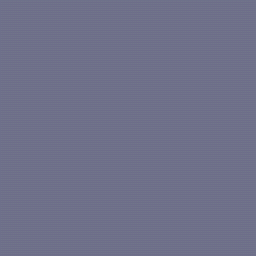

In [ ]:
output_image